In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.integrate import odeint
import pandas as pd
import itertools
import seaborn as sns


Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
You will investigate the five hallmarks of stochastic SIR dynamics using an event drive
SIR model:
1. variability;
2. negative co-variances;
3. increased transients;
4. stochastic resonance;
5. extinctions.


In [2]:
def sir(variables, t, beta, gamma, mu):
    S = variables[0]
    I = variables[1]
    R = variables[2]

    N = S + I + R

    dSdt = mu * N - beta * I * S / N - (mu * S)
    dIdt = beta * I * S / N - (gamma + mu) * I
    dRdt = gamma * I - mu * R

    return([dSdt, dIdt, dRdt])

Implement Gillespies algorithm
Write some python code to implement Gillespies Algorithm (GA)
1. You should define the
events and the rates of each event for the SIR model. Keep in mind it may be insightful
to compare the GA stochastic simulation with an equivalent deterministic ODE model.

In [3]:
def Gillespies(S_init, I_init, R_init, tend, beta, gamma, mu):
    # Initialize lists with initial conditions
    S = [S_init]
    I = [I_init]
    R = [R_init]
    t = [0]

    run_count = 0
    while t[-1] < tend and (S[-1] + I[-1] + R[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probabilities: [birth, transmission, recovery, 3x death]
        props = [mu * N, beta * I[-1] * S[-1] / N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        try:
            # Determine the time until the next event occurs based on the probability sum.
            tau = np.random.exponential(scale=1 / prop_sum)

            # Append new time point only once
            t_new = t[-1] + tau

            # Generate random number    
            rand = random.uniform(0, 1)

            # Determine which event occurs based on the random number and probabilities
            if rand * prop_sum <= props[0]:
                # Birth event
                S_new = S[-1] + 1
                I_new = I[-1]
                R_new = R[-1]

            elif rand * prop_sum <= props[0] + props[1]:
                # Transmission event
                S_new = S[-1] - 1
                I_new = I[-1] + 1
                R_new = R[-1]

            elif rand * prop_sum <= props[0] + props[1] + props[2]:
                # Recovery event
                S_new = S[-1]
                I_new = I[-1] - 1
                R_new = R[-1] + 1

            elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3]:
                # Death event in the susceptible compartment
                S_new = S[-1] - 1
                I_new = I[-1]
                R_new = R[-1]

            elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3] + props[4]:
                # Death event in the infected compartment
                S_new = S[-1]
                I_new = I[-1] - 1
                R_new = R[-1]

            else:
                # Death event in the recovered compartment
                S_new = S[-1]
                I_new = I[-1]
                R_new = R[-1] - 1

            # Append the new values to the lists
            S.append(S_new)
            I.append(I_new)
            R.append(R_new)
            t.append(t_new)

        except ZeroDivisionError:
            print(f"ZeroDivisionError, because prop_sum = 0, this happens when the population is all recovered or all susceptible, in other words when stochastic extinction happens (I = 1 at t=0, I = 0 at t = 1). Trying again, try count {run_count}")
            run_count += 1
            if run_count > 10:
                print("Stochastic extinction is happening too often, choose different parameters")
                break

    return S, I, R, t

In [4]:
# Initial conditions
S_init = 1000
I_init = 10
R_init = 0
t = 0

# Parameters
beta = 1
gamma = 0.5
mu = 0.05
tend = 500

In [5]:
# Initialization and simulation
n_runs = 3
results = []

max_length = 0  # Initialize max_length outside the loop

for i in range(n_runs):
    S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma, mu)

    # Update max_length if needed
    max_length = max(max_length, len(t))

    # Append results without interpolation for now
    results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

# Interpolate results to have consistent time points
interp_t = np.linspace(0, tend, max_length)
interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])
interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in results])

# Calculate mean after interpolation
mean_S = np.mean(interp_S, axis=0)
mean_I = np.mean(interp_I, axis=0)
mean_R = np.mean(interp_R, axis=0)

In [6]:
def RMSE(x, y):
    if not len(x) == len(y):
        raise ValueError("x and y must be of same length")
    return np.sqrt(np.mean(np.square(x - y)))

In [7]:
y0 = [S_init, I_init, R_init]
y = odeint(sir, y0, t, args=(beta, gamma, mu))

Text(0.5, 1.0, 'Gillespies SIR (mean) vs. ODE SIR')

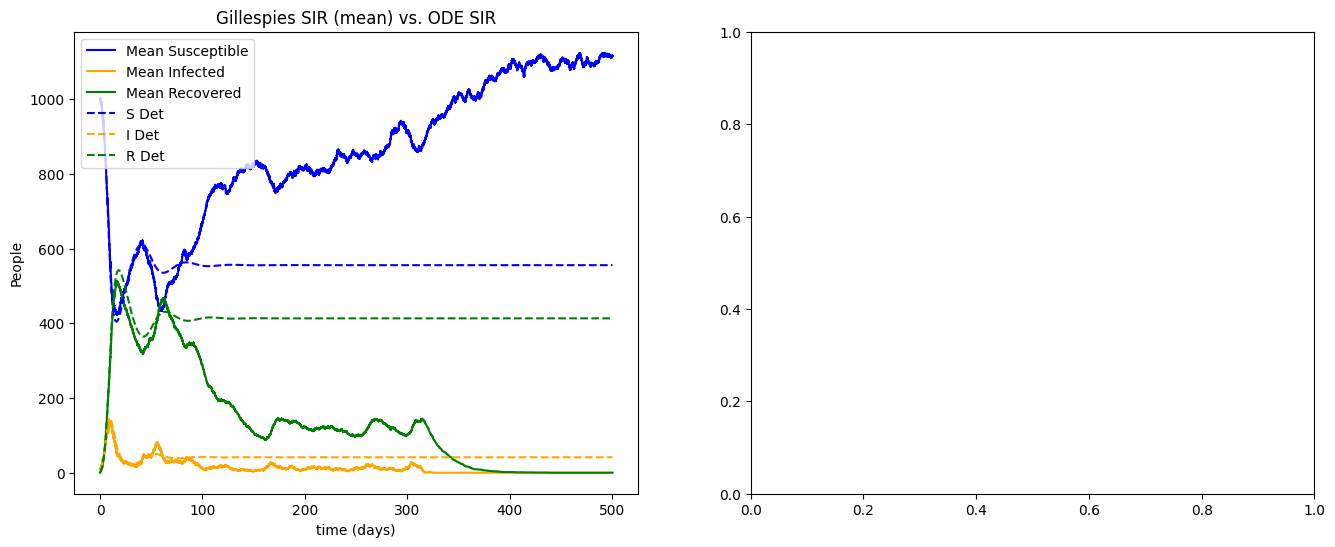

In [8]:
# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(interp_t, mean_S, label='Mean Susceptible', color='blue')
ax1.plot(interp_t, mean_I, label='Mean Infected', color='orange')
ax1.plot(interp_t, mean_R, label='Mean Recovered', color='green')
ax1.plot(t,y[:,0], label = "S Det", color='blue', ls='--') # S
ax1.plot(t,y[:,1], label = "I Det", color='orange', ls='--') # I
ax1.plot(t,y[:,2], label = "R Det", color='green', ls='--') # R
ax1.set_xlabel('time (days)')
ax1.set_ylabel('People')
ax1.legend()
ax1.set_title('Gillespies SIR (mean) vs. ODE SIR')


# Plot the differences
# ax2.plot(interp_t, interp_y[0] - mean_S[:len(interp_t)], label=f'Difference in Susceptible')
# ax2.plot(interp_t, interp_y[1] - mean_I[:len(interp_t)], label=f'Difference in Infected')
# ax2.plot(interp_t, interp_y[2] - mean_R[:len(interp_t)], label=f'Difference in Recovered')
# ax2.set_xlabel('time (days)')
# ax2.set_ylabel('Differences')
# ax2.legend()
# ax2.set_title('Differences between Gillespies and deterministic SIR ODE')
# fig.savefig('Residuals Gillespies vs. deterministic SIR.png')

BONUS: You can also think about (and implement) a way to control the noise level in
the GA.

Investigate Simulation Variability and Negative Co-variance
In the first experiment you should investigate how varying the model parameters changes
the behaviour of the stochastic dynamics, in particular how they relate to variance between
runs and how they impact negative covariance between S and I. Compare the mean of
the stochastic simulations with the equivalent deterministic model output (do this for
multiple settings of the model parameters).


In [9]:
# params
betas = np.round(np.linspace(0.5, 2, 3), 3)
gammas = np.round(np.linspace(0.1, 0.4, 3), 3)
combinations_beta_gamma = list(itertools.product(betas, gammas))


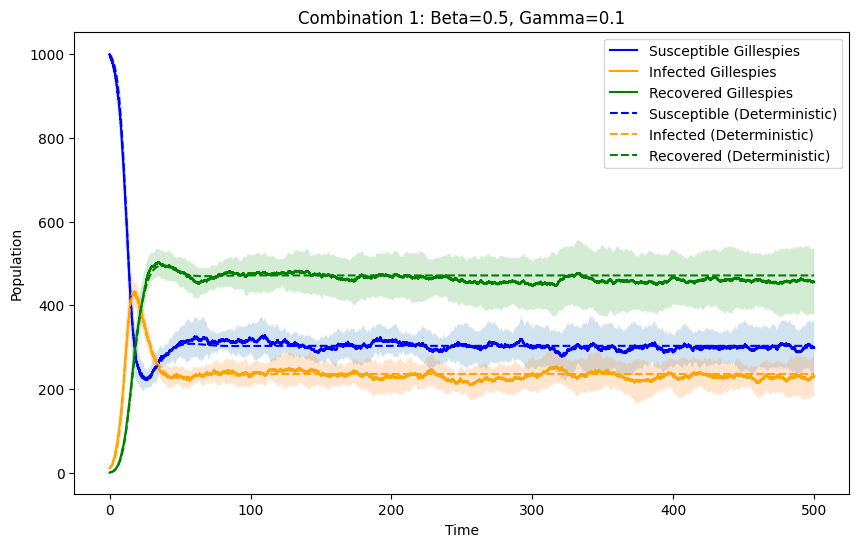

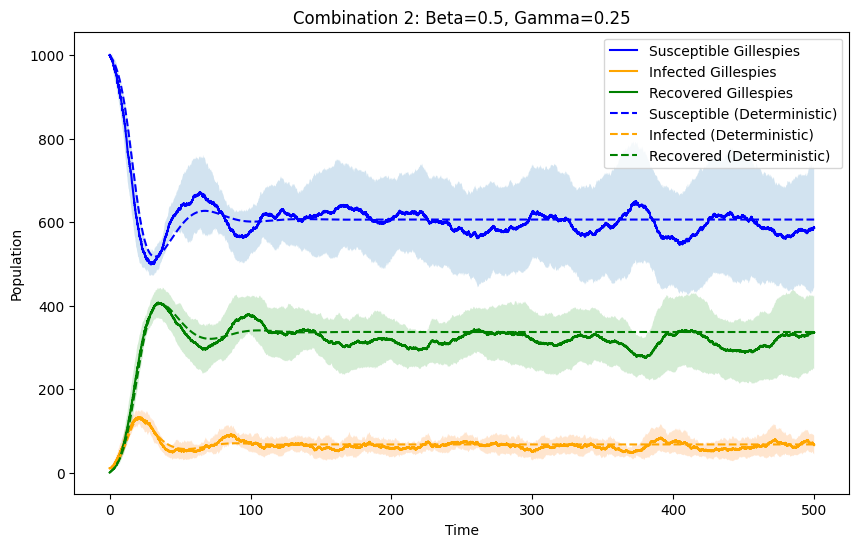

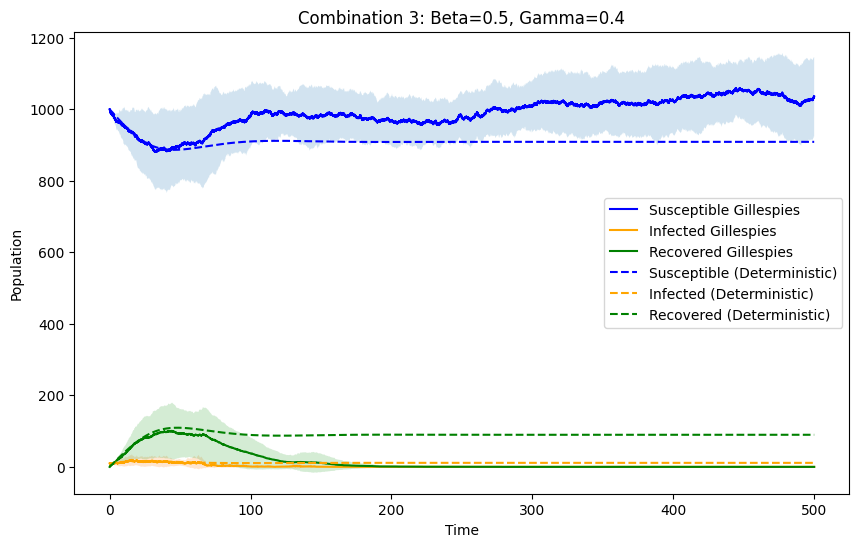

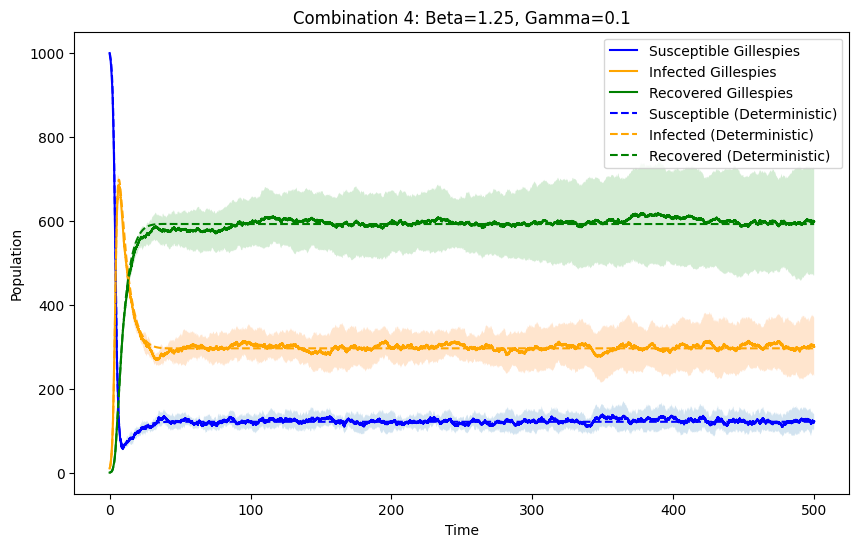

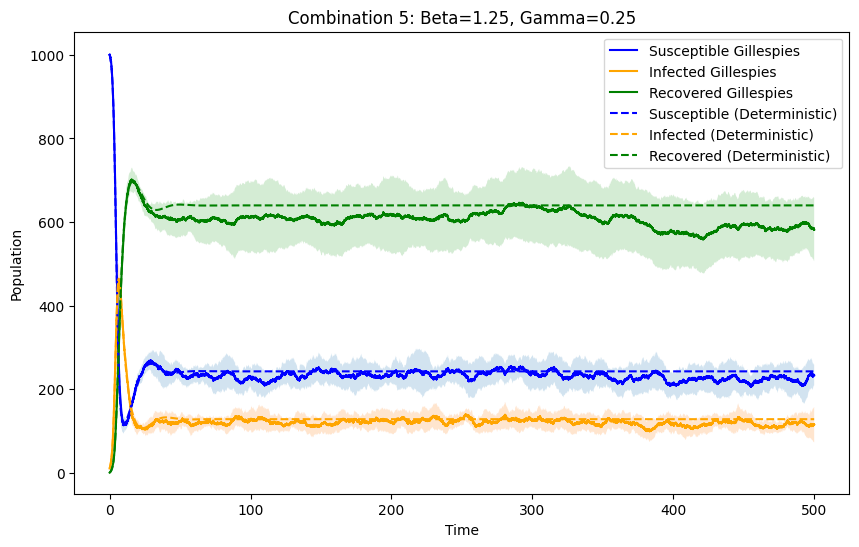

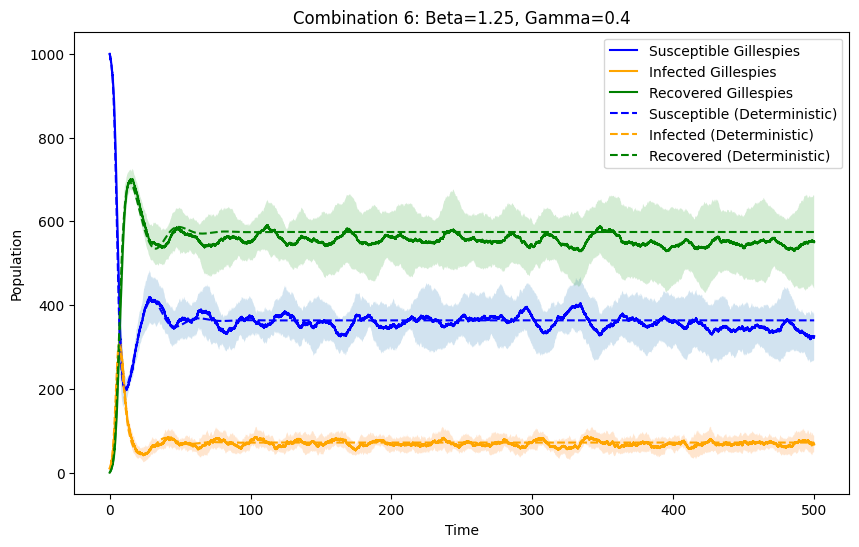

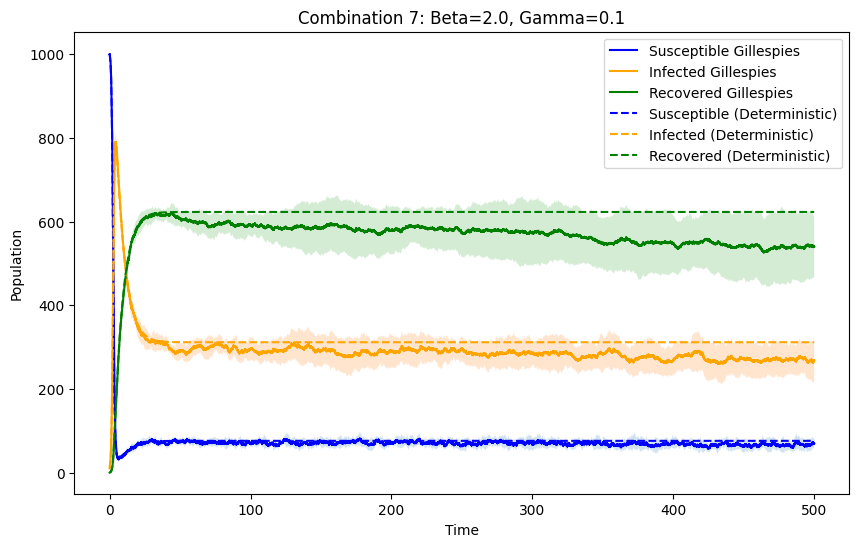

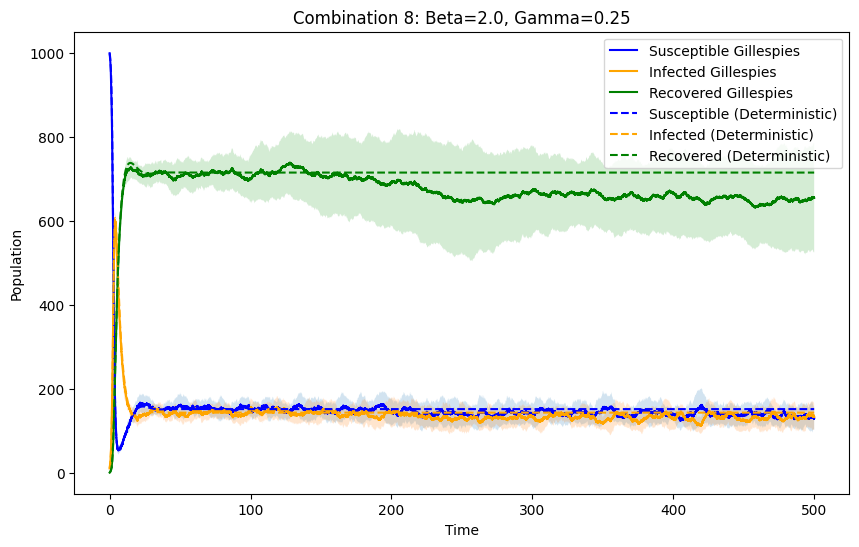

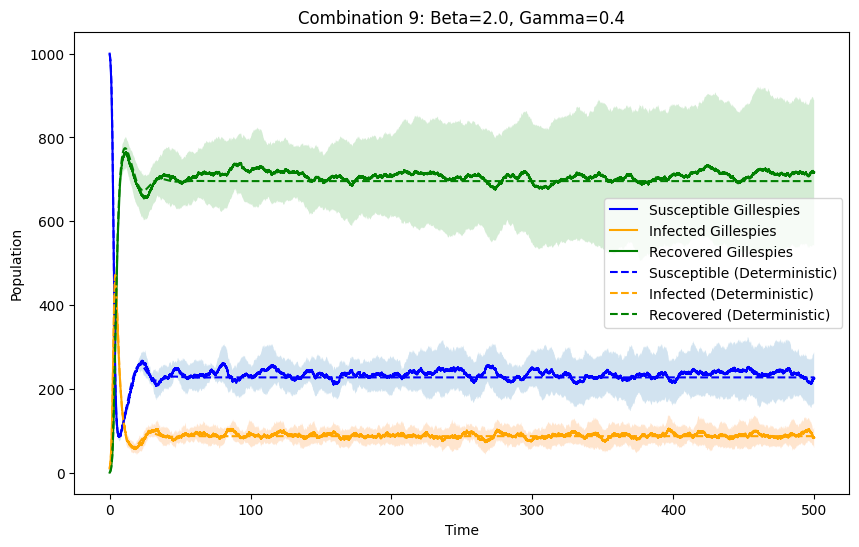

In [10]:
# Initialization and simulation
n_runs = 10
results = []

max_length = 0  # Initialize max_length outside the loop

for beta, gamma in combinations_beta_gamma:
    run_results = []

    for i in range(n_runs):
        S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma, mu)

        # Update max_length if needed
        max_length = max(max_length, len(t))

        # Append results without interpolation for now
        run_results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

    results.append(run_results)
    
# Interpolate results to have consistent time points for each combination
interp_results = []

for run_results in results:
    interp_t = np.linspace(0, tend, max_length)
    interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in run_results])
    interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in run_results])
    interp_R = np.array([np.interp(interp_t, result[3], result[2]) for result in run_results])

    interp_results.append((interp_S, interp_I, interp_R))

# Calculate mean after interpolation for each combination
mean_results = []

for interp_S, interp_I, interp_R in interp_results:
    mean_S = np.mean(interp_S, axis=0)
    mean_I = np.mean(interp_I, axis=0)
    mean_R = np.mean(interp_R, axis=0)

    mean_results.append((mean_S, mean_I, mean_R))


# Plot results for each combination
for idx, (beta, gamma) in enumerate(combinations_beta_gamma):
    plt.figure(figsize=(10, 6))

    plt.title(f'Combination {idx + 1}: Beta={beta}, Gamma={gamma}')
    plt.xlabel('Time')
    plt.ylabel('Population')

    mean_S, mean_I, mean_R = mean_results[idx]
    std_S = np.std(interp_results[idx][0], axis=0)  # Standard deviation for S
    std_I = np.std(interp_results[idx][1], axis=0)  # Standard deviation for I
    std_R = np.std(interp_results[idx][2], axis=0)  # Standard deviation for R

    plt.plot(interp_t, mean_S, label='Susceptible Gillespies', color='blue')
    plt.plot(interp_t, mean_I, label='Infected Gillespies', color='orange')
    plt.plot(interp_t, mean_R, label='Recovered Gillespies', color='green')

    # Fill between +/- one standard deviation
    plt.fill_between(interp_t, mean_S - std_S, mean_S + std_S, alpha=0.2)
    plt.fill_between(interp_t, mean_I - std_I, mean_I + std_I, alpha=0.2)
    plt.fill_between(interp_t, mean_R - std_R, mean_R + std_R, alpha=0.2)

    # Plot deterministic ODE model
    y_ode = odeint(sir, y0, interp_t, args=(beta, gamma, mu))
    plt.plot(interp_t, y_ode[:, 0], label='Susceptible (Deterministic)', color='blue', linestyle='--')
    plt.plot(interp_t, y_ode[:, 1], label='Infected (Deterministic)', color='orange', linestyle='--')
    plt.plot(interp_t, y_ode[:, 2], label='Recovered (Deterministic)', color='green', linestyle='--')


    plt.legend()
    plt.show()

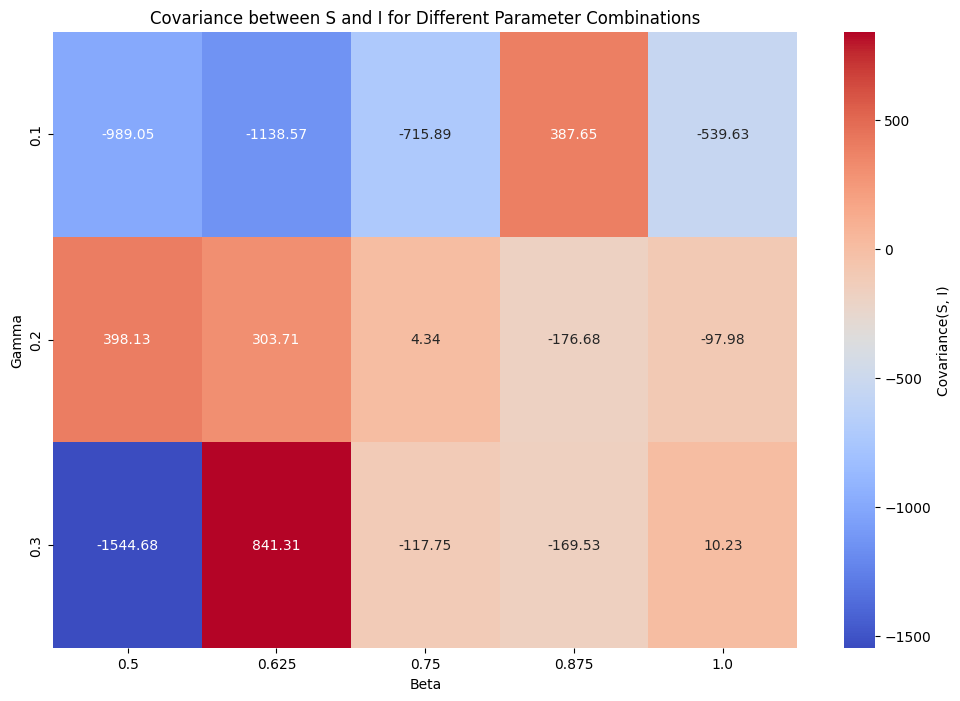

In [11]:
# Initialize lists to store results
covariances = []

# Vary parameters
for beta in np.linspace(0.5, 1, 5):
    for gamma in np.linspace(0.1, 0.3, 3):
        # Simulate the model for each combination of beta and gamma
        results = []

        for _ in range(n_runs):
            S, I, R, t = Gillespies(S_init, I_init, R_init, tend, beta, gamma, mu)
            results.append((np.array(S), np.array(I), np.array(R), np.array(t)))

        # Interpolate results to have consistent time points
        interp_t = np.linspace(0, tend, max_length)
        interp_S = np.array([np.interp(interp_t, result[3], result[0]) for result in results])
        interp_I = np.array([np.interp(interp_t, result[3], result[1]) for result in results])

        # Calculate covariance for each combination
        cov_matrix = np.cov(interp_S.flatten(), interp_I.flatten())
        covariance_SI = cov_matrix[0, 1]

        # Store results
        covariances.append((beta, gamma, covariance_SI))


# Extract data for heatmap
beta_values = [cov[0] for cov in covariances]
gamma_values = [cov[1] for cov in covariances]
covariance_values = [cov[2] for cov in covariances]

# Create a DataFrame for heatmap
data = {'Beta': beta_values, 'Gamma': gamma_values, 'Covariance': covariance_values}
df = pd.DataFrame(data)

# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap_data = df.pivot('Gamma', 'Beta', 'Covariance')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Covariance(S, I)'})
plt.title('Covariance between S and I for Different Parameter Combinations')
plt.show()



## Stochastic Resonance and Increased Transients
Show how the stochastic model can induce stochastic resonance around the equilibrium
and how that resonance relates the model parameters (e.g., N, β), etc). Show some
examples of increased transients away from the deterministic equilibrium - can you show
which parameter values lead to the largest transients.


In [12]:
def Gillespies_with_R0_and_population_stochastic_resonance(N_init, I_init, R_init, tend, R0, gamma, mu, noise_intensity):
    S_init = N_init - I_init - R_init
    beta = R0 * gamma
    S = [S_init]
    I = [I_init]
    R = [R_init]
    t = [0]

    while t[-1] < tend and (S[-1] + I[-1] + R[-1] >= 1):
        N = S[-1] + I[-1] + R[-1]
        props = [mu * N, beta * I[-1] * S[-1] / N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]

        # Introduce small random perturbations to the transmission and recovery rates
        perturbation = np.random.normal(loc=0, scale=noise_intensity)
        props[1] *= (1 + perturbation)
        props[2] *= (1 + perturbation)

        prop_sum = sum(props)
        tau = np.random.exponential(scale=1 / prop_sum)
        t_new = t[-1] + tau
        rand = random.uniform(0, 1)

        if rand * prop_sum <= props[0]:
            S_new = S[-1] + 1
            I_new = I[-1]
            R_new = R[-1]
        elif rand * prop_sum <= props[0] + props[1]:
            S_new = S[-1] - 1
            I_new = I[-1] + 1
            R_new = R[-1]
        elif rand * prop_sum <= props[0] + props[1] + props[2]:
            S_new = S[-1]
            I_new = I[-1] - 1
            R_new = R[-1] + 1
        elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3]:
            S_new = S[-1] - 1
            I_new = I[-1]
            R_new = R[-1]
        elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3] + props[4]:
            S_new = S[-1]
            I_new = I[-1] - 1
            R_new = R[-1]
        else:
            S_new = S[-1]
            I_new = I[-1]
            R_new = R[-1] - 1

        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
        t.append(t_new)

    return [S], [I], [R], [t]
 

In [13]:
N_init = 1000
I_init = 10
R_init = 0
tend = 1000
R0 = 3
gamma = 0.3
mu = 0.02
noise_intensity = 0.4

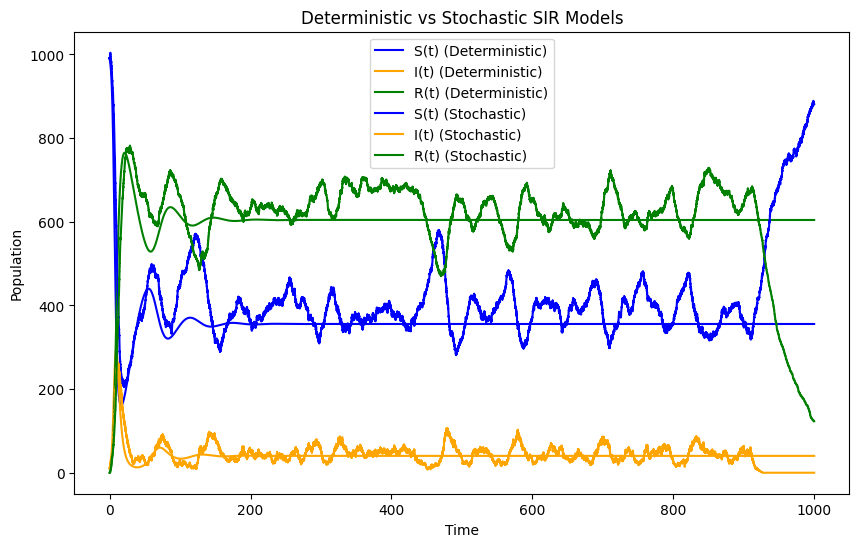

In [21]:
# Deterministic model
interp_t = np.linspace(0, tend, 1000)
y_ode = odeint(sir, [N_init - I_init - R_init, I_init, R_init], interp_t, args=(R0 * gamma, gamma, mu))

# Stochastic model
result_stochastic = Gillespies_with_R0_and_population_stochastic_resonance(N_init, I_init, R_init, tend, R0, gamma, mu, noise_intensity)

# Plotting
plt.figure(figsize=(10, 6))

# Plot deterministic model
plt.plot(interp_t, y_ode[:, 0], label='S(t) (Deterministic)', color='blue')
plt.plot(interp_t, y_ode[:, 1], label='I(t) (Deterministic)', color='orange')
plt.plot(interp_t, y_ode[:, 2], label='R(t) (Deterministic)', color='green')

# Plot stochastic model
plt.plot(result_stochastic[3][0], result_stochastic[0][0], label='S(t) (Stochastic)', color='blue')
plt.plot(result_stochastic[3][0], result_stochastic[1][0], label='I(t) (Stochastic)', color='orange')
plt.plot(result_stochastic[3][0], result_stochastic[2][0], label='R(t) (Stochastic)', color='green')

plt.title('Deterministic vs Stochastic SIR Models')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.show()

### Extinction events and Critical Community Size
In the lectures we have discussed the possibility of extinction of the virus even when
R0 > 1 in closed populations. Design an experiment to show how varying R0 impacts
the extinction process. Keep in mind that in the closed system randomness will always
eventually lead to extinction. Now look at how the extinction events are impacted by
the population size. Find a way to show how the two parameters R0 and N interact to
impact the extinction process.

In [22]:
def Gillespies_with_R0_and_population(N_init, I_init, R_init, tend, R0, gamma, mu):
    # Calculate initial susceptible based on total population size
    S_init = N_init - I_init - R_init

    # Calculate beta based on R0
    beta = R0 * gamma

    extinction_count = 0

    # Initialize lists with initial conditions
    S = [S_init]
    I = [I_init]
    R = [R_init]
    t = [0]

    while t[-1] < tend and (S[-1] + I[-1] + R[-1] >= 1):
        # Get Population
        N = S[-1] + I[-1] + R[-1]

        # Get the probabilities: [S -> I, I -> R]
        props = [mu * N, beta * I[-1] * S[-1] / N, gamma * I[-1], mu * S[-1], mu * I[-1], mu * R[-1]]

        # Get sum of probability
        prop_sum = sum(props)

        # Determine the time until the next event occurs based on the probability sum.
        tau = np.random.exponential(scale=1 / prop_sum)

        # Append new time point only once
        t_new = t[-1] + tau

        # Generate random number    
        rand = random.uniform(0, 1)

        # Determine which event occurs based on the random number and probabilities
        if rand * prop_sum <= props[0]:
            # Birth event
            S_new = S[-1] + 1
            I_new = I[-1]
            R_new = R[-1]

        elif rand * prop_sum <= props[0] + props[1]:
            # Transmission event
            S_new = S[-1] - 1
            I_new = I[-1] + 1
            R_new = R[-1]

        elif rand * prop_sum <= props[0] + props[1] + props[2]:
            # Recovery event
            S_new = S[-1]
            I_new = I[-1] - 1
            R_new = R[-1] + 1

        elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3]:
            # Death event in the susceptible compartment
            S_new = S[-1] - 1
            I_new = I[-1]
            R_new = R[-1]

        elif rand * prop_sum <= props[0] + props[1] + props[2] + props[3] + props[4]:
            # Death event in the infected compartment
            S_new = S[-1]
            I_new = I[-1] - 1
            R_new = R[-1]

        else:
            # Death event in the recovered compartment
            S_new = S[-1]
            I_new = I[-1]
            R_new = R[-1] - 1

        # Check if the disease has gone extinct
        if I_new == 0 and R_new == 0:
            extinction_count += 1
            break

        # Append the new values to the lists
        S.append(S_new)
        I.append(I_new)
        R.append(R_new)
        t.append(t_new)

    return [S], [I], [R], [t], extinction_count

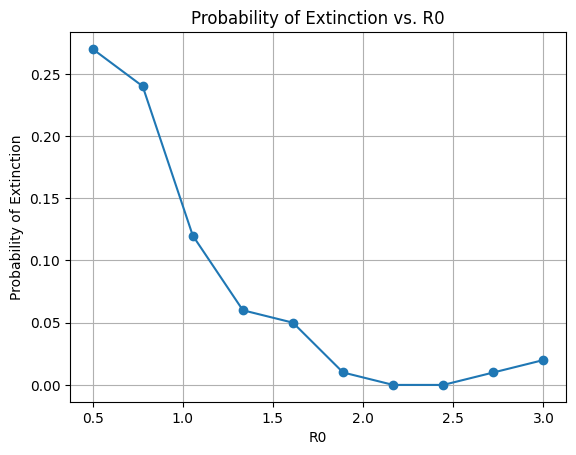

In [23]:
# Parameters for simulation
N_init = 1000
I_init = 5
R_init = 0
tend = 100
gamma = 0.1
mu = 0.02

# Range of R0 values
R0_values = np.linspace(0.5, 3.0, 10)

# Number of simulations for each R0 value
num_simulations = 100

# List to store probability of extinction for each R0 value
extinction_probabilities = []

for R0 in R0_values:
    extinction_count_total = 0

    for _ in range(num_simulations):
        result = Gillespies_with_R0_and_population(N_init, I_init, R_init, tend, R0, gamma, mu)
        extinction_count_total += result[-1]

    extinction_probability = extinction_count_total / num_simulations
    extinction_probabilities.append(extinction_probability)

# Plotting
plt.plot(R0_values, extinction_probabilities, marker='o')
plt.title('Probability of Extinction vs. R0')
plt.xlabel('R0')
plt.ylabel('Probability of Extinction')
plt.grid(True)
plt.show()

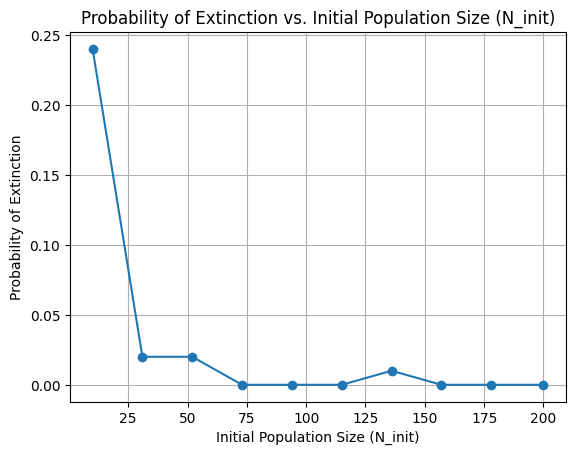

In [24]:
# Range of N_init values
N_init_values = np.linspace(10, 200, 10, dtype=int)

# Number of simulations for each N_init value
num_simulations = 100

# List to store probability of extinction for each N_init value
extinction_probabilities = []

for N_init in N_init_values:
    extinction_count_total = 0

    for _ in range(num_simulations):
        result = Gillespies_with_R0_and_population(N_init, I_init, R_init, tend, R0, gamma, mu)
        extinction_count_total += result[-1]

    extinction_probability = extinction_count_total / num_simulations
    extinction_probabilities.append(extinction_probability)

# Plotting
plt.plot(N_init_values, extinction_probabilities, marker='o')
plt.title('Probability of Extinction vs. Initial Population Size (N_init)')
plt.xlabel('Initial Population Size (N_init)')
plt.ylabel('Probability of Extinction')
plt.grid(True)
plt.show()

In [25]:
# Create meshgrid for R0 and N_init
R0_mesh, N_init_mesh = np.meshgrid(R0_values, N_init_values)

# Initialize array for storing probability of extinction
extinction_probabilities = np.zeros_like(R0_mesh, dtype=float)


In [26]:
# Number of simulations for each combination of R0 and N_init
num_simulations = 100

# Perform simulations
for i in range(len(R0_values)):
    for j in range(len(N_init_values)):
        R0 = R0_values[i]
        N_init = N_init_values[j]
        extinction_count_total = 0

        for _ in range(num_simulations):
            result = Gillespies_with_R0_and_population(N_init, I_init, R_init, tend, R0, gamma, mu)
            extinction_count_total += result[-1]

        extinction_probability = extinction_count_total / num_simulations
        extinction_probabilities[j, i] = extinction_probability


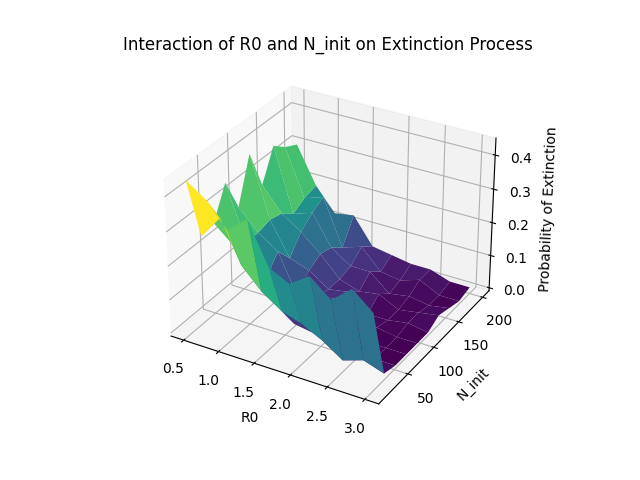

In [27]:
# Enable interactive mode
%matplotlib widget 

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(R0_mesh, N_init_mesh, extinction_probabilities, cmap='viridis')

ax.set_xlabel('R0')
ax.set_ylabel('N_init')
ax.set_zlabel('Probability of Extinction')
ax.set_title('Interaction of R0 and N_init on Extinction Process')

# Display the plot
plt.show()